# First SageMaker Notebook

In [1]:
# Define IAM role
import boto3
from sagemaker import get_execution_role

In [11]:
bucket = 'sagemaker-test-mdebbich'
# If you don't have any specific bucket you can automatically create one using :
# bucket = Session().default_bucket()

prefix = 'test-iris/linear-model'
role = get_execution_role()
role

'arn:aws:iam::553243691765:role/service-role/AmazonSageMaker-ExecutionRole-20190304T180164'

# Data Exploration

In [3]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import numpy as np

Load Iris Data :

In [4]:
iris = datasets.load_iris()
iris_data = pd.DataFrame(iris["data"], columns= iris["feature_names"])
iris_data["target"] = iris["target"]
iris_data["species"] = iris["target"]
iris_data["species"] = iris_data["species"].astype("category").cat.rename_categories(iris["target_names"])

In [5]:
iris_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


Text(0,0.5,'Sepal width')

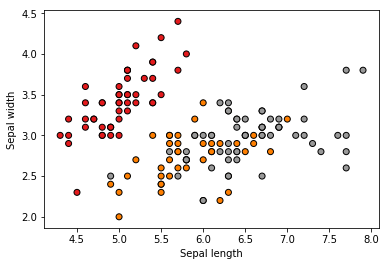

In [6]:
# Plot the training points
plt.scatter(iris_data.iloc[:, 0], iris_data.iloc[:, 1], c=iris_data["target"], cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')


# Model Training

In [7]:
from sagemaker import LinearLearner
from sklearn.model_selection import train_test_split

In [8]:
train, test = train_test_split(iris_data, train_size=0.8)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [20]:
train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
0,5.8,2.6,4.0,1.2,1,versicolor
1,4.9,2.5,4.5,1.7,2,virginica
2,5.5,3.5,1.3,0.2,0,setosa
3,4.8,3.0,1.4,0.3,0,setosa
4,4.9,3.0,1.4,0.2,0,setosa


Define Training job:

In [15]:
data_location = 's3://{}/{}/train_data'.format(bucket, prefix)
output_location = 's3://{}/{}/output'.format(bucket, prefix)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

linear = LinearLearner(
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    output_path=output_location,
    data_location=data_location,
    predictor_type="multiclass_classifier",
    num_classes=3
)


training data will be uploaded to: s3://sagemaker-test-mdebbich/test-iris/linear-model/train_data
training artifacts will be uploaded to: s3://sagemaker-test-mdebbich/test-iris/linear-model/output


### Data conversion

In [41]:
train_input = np.array(train)

vectors = train_input[:, :4].astype("float32")
labels = train_input[:, 4].astype("float32")

Run the training job:

In [ ]:
recorded_train_set = linear.record_set(vectors, labels=labels)

In [42]:
linear.fit(recorded_train_set)

INFO:sagemaker:Creating training-job with name: linear-learner-2019-03-07-17-09-02-166


2019-03-07 17:09:02 Starting - Starting the training job...
2019-03-07 17:09:03 Starting - Launching requested ML instances......
2019-03-07 17:10:07 Starting - Preparing the instances for training......
2019-03-07 17:11:29 Downloading - Downloading input data...
2019-03-07 17:11:56 Training - Training image download completed. Training in progress.
2019-03-07 17:11:56 Uploading - Uploading generated training model
Docker entrypoint called with argument(s): train
[03/07/2019 17:11:51 INFO 140277105186624] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'unifor

# Model Deployment

In [44]:
linear_predictor = linear.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name='linear'
)

INFO:sagemaker:Creating model with name: linear-learner-2019-03-07-17-24-38-590
INFO:sagemaker:Creating endpoint with name linear


---------------------------------------------------------------------------------------!

# Endpoint Test

In [47]:
test_data_location = 's3://{}/{}/test_data'.format(bucket, prefix)

In [48]:
test_data_location

's3://sagemaker-test-mdebbich/test-iris/linear-model/test_data'

In [49]:
test_input = np.array(test)

test_vectors = test_input[:, :4].astype("float32")
test_labels = test_input[:, 4].astype("float32")

In [51]:
results = linear_predictor.predict(
    test_vectors
)

In [50]:
help(linear_predictor.predict)

Help on method predict in module sagemaker.predictor:

predict(data, initial_args=None) method of sagemaker.amazon.linear_learner.LinearLearnerPredictor instance
    Return the inference from the specified endpoint.
    
    Args:
        data (object): Input data for which you want the model to provide inference.
            If a serializer was specified when creating the RealTimePredictor, the result of the
            serializer is sent as input data. Otherwise the data must be sequence of bytes, and
            the predict method then sends the bytes in the request body as is.
        initial_args (dict[str,str]): Optional. Default arguments for boto3
            ``invoke_endpoint`` call. Default is None (no default arguments).
    
    Returns:
        object: Inference for the given input. If a deserializer was specified when creating
            the RealTimePredictor, the result of the deserializer is returned. Otherwise the response
            returns the sequence of bytes as 

In [59]:
classes = np.array([res.label["predicted_label"].float32_tensor.values[0] for res in results])

In [64]:
(classes == test_labels).sum() / len(test_labels)

0.9333333333333333

In [66]:
# Delete the endpoint:
# linear_predictor.delete_endpoint()